In [694]:
!pip install -U portalocker>=2.0.0

zsh:1: 2.0.0 not found


## Task - 1

### PyTorch FC ANN MNIST Implementation.

In [695]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

import keras_tuner as kt

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [696]:
# Transformations --> this is a "pre-processing step" that's typical for image processing methods
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image or numpy.ndarray to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize data to range [-1, 1]
])
# This dataset is already "sorted" as part of the import method, but no "validation" set has been selected in this case
# Loading the FashionMNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)



In [697]:
# Mapping the labels for the MNIST dataset -- later we'll see that this using the "keras to_categorical" method as discussed in class
labels_map = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4",
    5: "5", 6: "6", 7: "7", 8: "8", 9: "9"
}

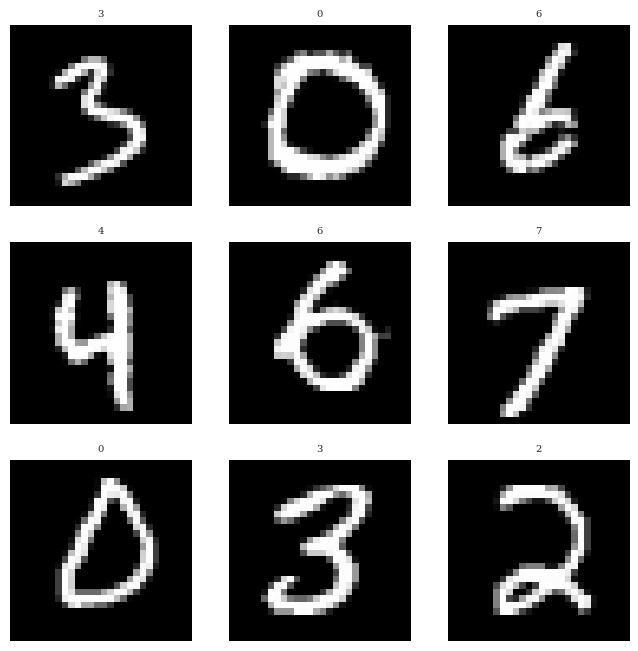

In [698]:
#This cell is designed to display a few images from the dataset
#It isn't necessary to run this, but it can help give a better idea of the challanges your model will face
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

# Displaying figures from the dataset randomly
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [699]:
#Here we define the model parameters -- the general strucutre as provided here will produce a fully connected network [28x28] --> 32 --> 16 --> 10

mps_device = torch.device("mps")

class MLP(nn.Module): #MLP stands for "Multi-Layer Perceptron"
    def __init__(self, hidden_topology, hidden_activations): #this initializes the structure of the network
        super(MLP, self).__init__()
        self.hidden_topology = hidden_topology
        self.hidden_activations = hidden_activations
        self.fc1 = nn.Linear(28 * 28, self.hidden_topology[0]) ## First fully connected linear layer, 28*28 input features and 32 outputs
        self.fcharr = []
        for i in range(1, len(self.hidden_topology)):
            self.fcharr.append(nn.Linear(self.hidden_topology[i-1], self.hidden_topology[i]))
            # self.fcharr[i-1].to(mps_device)
        self.fc3 = nn.Linear(self.hidden_topology[len(self.hidden_topology)-1], 10) ## 10 output features because MNIST has 10 target classes
        # self.to(mps_device)


    def forward(self, x): #this modifies the elements of the intial structure defined above
        x = x.view(-1, 28 * 28) #the array is sent in as a vector
        x = self.hidden_activations[0](self.fc1(x))
        for i in range(1, len(self.hidden_topology)):
            x = self.hidden_activations[i](self.fcharr[i-1](x))

        x = self.fc3(x)
        
        # x = torch.sigmoid(self.fc1(x)) ## Applying sigmoid activation for the first layer
        # x = torch.tanh(self.fc2(x)) ## Applying tanh activation for the second layer
        # x = self.fc3(x) ## no modifications to the activation of the output layer
        return x


In [703]:


model_topologies = [
    [32,16],
    [32,32],
    [24,24],
    [24,23],
    [64,32],
    [16,16,16],
    [32,16,8],
    [64,32,16],
    [16,16,16,16],
    [32,16,16,8],
    [64,32,24,16],
]

activation_functions_2_layer = [
    [torch.sigmoid, torch.tanh],
    [torch.tanh, torch.tanh],
    [torch.tanh, torch.relu],
]

activation_functions_3_layer = [
    [torch.sigmoid, torch.tanh, torch.relu],
    [torch.tanh, torch.tanh, torch.relu],
    [torch.tanh, torch.relu, torch.relu],
]

activation_functions_4_layer = [
    [torch.sigmoid, torch.tanh, torch.relu, torch.relu],
    [torch.tanh, torch.tanh, torch.relu, torch.relu],
    [torch.tanh, torch.relu, torch.relu, torch.relu],
]

learning_rates = [0.002, 0.004, 0.008, 0.02 ,0.04, 0.08, 0.2]
batch_sizes = [32,64,128]

net_results_2_layer = []
net_results_3_layer = []
net_results_4_layer = []

# Training and Testing loaders

for i in range(len(model_topologies)):
    model_topology = model_topologies[i]
    net_results = []    
    layer_count = len(model_topology)
    if(len(model_topology) == 2):
        activation_functions = activation_functions_2_layer
        net_results = net_results_2_layer
    elif(len(model_topology) == 3):
        activation_functions = activation_functions_3_layer
        net_results = net_results_3_layer
    elif(len(model_topology) == 4):
        activation_functions = activation_functions_4_layer
        net_results = net_results_4_layer

    for j in range(len(activation_functions)):
        act_func_list = ','.join(x.__name__ for x in activation_functions[j])
        for k in range(len(learning_rates)):
            for m in range(len(batch_sizes)):
                print(f'{model_topology} {act_func_list} {learning_rates[k]} {batch_sizes[m]}')

                #Create string of parameters for the model
                run_name = f'SGD_{layer_count}_layer-{model_topology}_{act_func_list}_{learning_rates[k]}_{batch_sizes[m]}'

                #check if the file already exists
                try:
                    results_file = open(run_name + '.json', 'r')
                    results_file.close()

                    #read the json and create array
                    results = pd.read_json(run_name + '.json', lines=True)
                    accuracy = results['accuracy']
                    topology = results['model_topology']
                    act_func = results['activation_functions']
                    learn_rate = results['learning_rate']
                    batch_size = results['batch_size']

                    #append to net_results
                    net_results.append([accuracy, topology, act_func, learn_rate])
                    continue
                except:
                    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_sizes[m], shuffle=True)
                    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_sizes[m], shuffle=False)

                    #run each model 10 times and average the results
                    model = MLP(model_topology, activation_functions[j])
                    criterion = nn.CrossEntropyLoss()
                    optimizer = optim.SGD(model.parameters(), lr=learning_rates[k])

                    num_epochs = 25
                    for epoch in range(num_epochs):
                        model.train()
                        running_loss = 0.0
                        for i, data in enumerate(train_loader, 0):
                            inputs, labels = data
                            # inputs = inputs.to(mps_device)
                            # labels = labels.to(mps_device)
                            optimizer.zero_grad()

                            outputs = model(inputs)
                            loss = criterion(outputs, labels)
                            loss.backward()
                            optimizer.step()
                            running_loss += loss.item()
                            # if i % 1000 == 999:
                            #     # print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
                            #     running_loss = 0.0

                    model.eval()
                    correct = 0
                    total = 0
                    with torch.no_grad():
                        for data in test_loader:
                            images, labels = data
                            # images = images.to(mps_device)
                            # labels = labels.to(mps_device)
                            outputs = model(images)
                            _, predicted = torch.max(outputs.data, 1)
                            total += labels.size(0)
                            correct += (predicted == labels).sum().item()

                    results_file = open(run_name + '.json', 'a')

                    #write results to json file
                    #{accuracy: 0.0, model_topology: [32,16], activation_functions: [sigmoid, tanh], learning_rate: 0.002}
                    results_file.write(f'{{"accuracy": {100*(correct / total):.2f}, "model_topology": \"{model_topology}\", "activation_functions": \"{act_func_list}\", "learning_rate": {learning_rates[k]},"batch_size": {batch_sizes[m]}}}\n')
                    results_file.close()


                    print(f'{100*(correct / total):.2f}%')
                    net_results.append([100*(correct / total), f'{model_topology}', act_func_list, learning_rates[k], batch_sizes[m]])
                # print(f'Model Topology: {model_topology}')
                # print(f'Activation Functions: {activation_functions[j]}')
                # print(f'Learning Rate: {learning_rates[k]}')
                # print(f'Accuracy on test set: { 100*(correct / total)}%')


print('Finished Training')

[32, 16] sigmoid,tanh 0.002 32
[32, 16] sigmoid,tanh 0.002 64
[32, 16] sigmoid,tanh 0.002 128
[32, 16] sigmoid,tanh 0.004 32
[32, 16] sigmoid,tanh 0.004 64
[32, 16] sigmoid,tanh 0.004 128
[32, 16] sigmoid,tanh 0.008 32
[32, 16] sigmoid,tanh 0.008 64
[32, 16] sigmoid,tanh 0.008 128
[32, 16] sigmoid,tanh 0.02 32
[32, 16] sigmoid,tanh 0.02 64
[32, 16] sigmoid,tanh 0.02 128
[32, 16] sigmoid,tanh 0.04 32
[32, 16] sigmoid,tanh 0.04 64
[32, 16] sigmoid,tanh 0.04 128
[32, 16] sigmoid,tanh 0.08 32
[32, 16] sigmoid,tanh 0.08 64
[32, 16] sigmoid,tanh 0.08 128
[32, 16] sigmoid,tanh 0.2 32
[32, 16] sigmoid,tanh 0.2 64
[32, 16] sigmoid,tanh 0.2 128
[32, 16] tanh,tanh 0.002 32
[32, 16] tanh,tanh 0.002 64
[32, 16] tanh,tanh 0.002 128
[32, 16] tanh,tanh 0.004 32
[32, 16] tanh,tanh 0.004 64
[32, 16] tanh,tanh 0.004 128
[32, 16] tanh,tanh 0.008 32
[32, 16] tanh,tanh 0.008 64
[32, 16] tanh,tanh 0.008 128
[32, 16] tanh,tanh 0.02 32
[32, 16] tanh,tanh 0.02 64
[32, 16] tanh,tanh 0.02 128
[32, 16] tanh,tanh 0

In [704]:
df2 = pd.DataFrame(net_results_2_layer, columns=['Accuracy', 'Model Topology', 'Activation Functions', 'Learning Rate', 'Batch Size'])
df3 = pd.DataFrame(net_results_3_layer, columns=['Accuracy', 'Model Topology', 'Activation Functions', 'Learning Rate', 'Batch Size'])
df4 = pd.DataFrame(net_results_4_layer, columns=['Accuracy', 'Model Topology', 'Activation Functions', 'Learning Rate', 'Batch Size'])


#Plot accuracy vs log(learning rate) for each model topology and activation function combination
sns.set_theme(style="whitegrid", font='serif', font_scale=0.6)


g = sns.FacetGrid(df2, row='Model Topology', col='Activation Functions', margin_titles=True)
g.map(sns.lineplot, 'Learning Rate', 'Accuracy')
g.set_axis_labels('Learning Rate', 'Accuracy')
g.add_legend()
plt.xscale('log')
plt.show()

g = sns.FacetGrid(df3, row='Model Topology', col='Activation Functions', margin_titles=True)
g.map(sns.lineplot, 'Learning Rate', 'Accuracy')
g.set_axis_labels('Learning Rate', 'Accuracy')
g.add_legend()
plt.xscale('log')
plt.show()

g = sns.FacetGrid(df4, row='Model Topology', col='Activation Functions', margin_titles=True)
g.map(sns.lineplot, 'Learning Rate', 'Accuracy')
g.set_axis_labels('Learning Rate', 'Accuracy')
g.add_legend()
plt.xscale('log')
plt.show()


ValueError: 5 columns passed, passed data had 4 columns

In [295]:
# Evaluating the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: { 100*(correct / total)}%')

Accuracy on test set: 72.86%


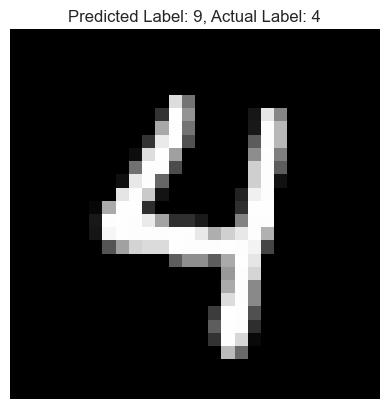

In [296]:
image_index = 27
test_image, test_label = test_dataset[image_index]

with torch.no_grad():
    model.eval()
    output = model(test_image.unsqueeze(0))
    _, predicted_label = torch.max(output, 1)

test_image_numpy = test_image.squeeze().numpy()

plt.imshow(test_image_numpy, cmap='gray')
plt.title(f'Predicted Label: {predicted_label.item()}, Actual Label: {test_label}')
plt.axis('off')
plt.show()

Notes for Part 1

1. Activation fucntion:

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))  # Change activation function here
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

2. loss function and optimizer

model = Net()
criterion = torch.nn.CrossEntropyLoss()  # Change loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

3. ~adding a dropout layer

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 128)
        self.dropout = torch.nn.Dropout(0.2)  # Add a Dropout layer here
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply Dropout
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

4. model configurations / epochs

epochs = 10  # Change number of epochs
for epoch in range(epochs):
    # Training loop
    for i, data in enumerate(train_loader, 0):
        # Training steps

## Task - 2

### PyTorch FC ANN FMNIST Implementation


In [297]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [298]:
# Transformations --> this is a "pre-processing step" that's typical for image processing methods
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image or numpy.ndarray to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize data to range [-1, 1]
])
# This dataset is already "sorted" as part of the import method, but no "validation" set has been selected in this case
# Loading the FashionMNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Training and Testing loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [299]:
# Mapping the labels for the MNIST dataset -- later we'll see that this using the "keras to_categorical" method as discussed in class
labels_map = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4",
    5: "5", 6: "6", 7: "7", 8: "8", 9: "9"
}

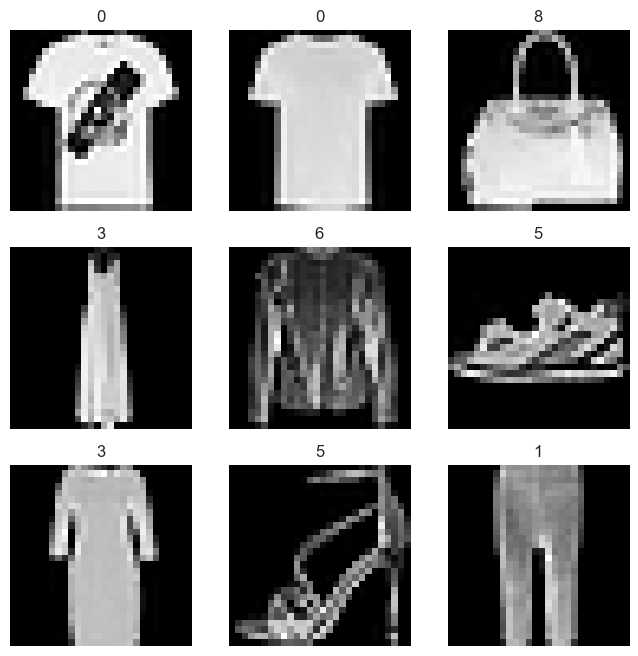

In [300]:
#This cell is designed to display a few images from the dataset
#It isn't necessary to run this, but it can help give a better idea of the challanges your model will face
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

# Displaying figures from the dataset randomly
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [301]:
#Here we define the model parameters -- the general strucutre as provided here will produce a fully connected network [28x28] --> 32 --> 16 --> 10
class MLP(nn.Module): #MLP stands for "Multi-Layer Perceptron"
    def __init__(self): #this initializes the structure of the network
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 32) ## First fully connected linear layer, 28*28 input features and 32 outputs
        self.fc2 = nn.Linear(32 , 16) ## Second fully connected linear layer, 32 inputs and 16 outputs
        self.fc3 = nn.Linear(16, 10) ## 10 output features because MNIST has 10 target classes

    def forward(self, x): #this modifies the elements of the intial structure defined above
        x = x.view(-1, 28 * 28) #the array is sent in as a vector
        x = torch.sigmoid(self.fc1(x)) ## Applying sigmoid activation for the first layer
        x = torch.tanh(self.fc2(x)) ## Applying tanh activation for the second layer
        x = self.fc3(x) ## no modifications to the activation of the output layer
        return x

# Initializing the neural network
model = MLP()

In [302]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002)

# Training the neural network
num_epochs = 9
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0

print('Finished Training')

Epoch 1, Batch 100, Loss: 2.3092327547073364
Epoch 1, Batch 200, Loss: 2.2942226004600523
Epoch 1, Batch 300, Loss: 2.279485487937927
Epoch 1, Batch 400, Loss: 2.2643858671188353
Epoch 1, Batch 500, Loss: 2.2518870854377746
Epoch 1, Batch 600, Loss: 2.2394341468811034
Epoch 1, Batch 700, Loss: 2.2233759331703187
Epoch 1, Batch 800, Loss: 2.2101558160781862
Epoch 1, Batch 900, Loss: 2.1955674505233764
Epoch 2, Batch 100, Loss: 2.1743762993812563
Epoch 2, Batch 200, Loss: 2.158717300891876
Epoch 2, Batch 300, Loss: 2.138843719959259
Epoch 2, Batch 400, Loss: 2.124714708328247
Epoch 2, Batch 500, Loss: 2.099507575035095
Epoch 2, Batch 600, Loss: 2.0802184104919434
Epoch 2, Batch 700, Loss: 2.062397301197052
Epoch 2, Batch 800, Loss: 2.034111989736557
Epoch 2, Batch 900, Loss: 2.011344039440155
Epoch 3, Batch 100, Loss: 1.9797982275485992
Epoch 3, Batch 200, Loss: 1.953240214586258
Epoch 3, Batch 300, Loss: 1.9322712624073028
Epoch 3, Batch 400, Loss: 1.9050440895557403
Epoch 3, Batch 500,

In [303]:
# Evaluating the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: { correct / total}%')

Accuracy on test set: 0.6422%


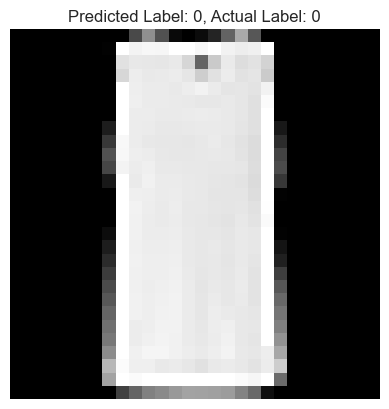

In [304]:
image_index = 27
test_image, test_label = test_dataset[image_index]

with torch.no_grad():
    model.eval()
    output = model(test_image.unsqueeze(0))
    _, predicted_label = torch.max(output, 1)

test_image_numpy = test_image.squeeze().numpy()

plt.imshow(test_image_numpy, cmap='gray')
plt.title(f'Predicted Label: {predicted_label.item()}, Actual Label: {test_label}')
plt.axis('off')
plt.show()

## PART - 3

### FMNIST CNN Implimentation with Keras

In [305]:
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.optimizers import SGD
from keras.utils import to_categorical
import numpy as np

In [306]:
# Mapping the labels for the MNIST dataset
labels_map = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4",
    5: "5", 6: "6", 7: "7", 8: "8", 9: "9"
}

In [307]:
# Load and preprocess the data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [308]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Preprocess the data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [309]:
model = Sequential([
    Conv2D(16, (3, 3), activation='sigmoid', input_shape=(28, 28, 1)),  # 16 filters (reduced), 3x3 kernel
    MaxPooling2D(pool_size=(5, 5)),  # Max pooling with 2x2 pool size
    # Flatten the output before passing to Dense layers
    Flatten(),
    Dense(64, activation='softmax'),  # Reduced from 128 to 64 units
    Dense(10, activation='softmax')  # Output layer with 10 units for classification
])

## change the architecture with CONV2D, Pooling, and Dense.

/Users/thomasjones/.pyenv/versions/3.10.15/envs/MLExp/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [310]:
learning_rate = 0.01
epochs = 5
batch_size = 48

# Compile the model
model.compile(optimizer=SGD(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [311]:
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print('Test accuracy:', accuracy)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.0988 - loss: 2.3026
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.1070 - loss: 2.3021
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.1286 - loss: 2.3018
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.1431 - loss: 2.3014
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.1171 - loss: 2.3006
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1213 - loss: 2.2994
Test accuracy: 0.120899997651577


In [312]:
from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train the model with early stopping
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print('Test accuracy:', accuracy)

Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.1187 - loss: 2.2987 - val_accuracy: 0.0981 - val_loss: 2.2965
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.1349 - loss: 2.2947 - val_accuracy: 0.1762 - val_loss: 2.2882
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.1593 - loss: 2.2827 - val_accuracy: 0.1956 - val_loss: 2.2520
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.1958 - loss: 2.2301 - val_accuracy: 0.1882 - val_loss: 2.1444
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.1995 - loss: 2.1159 - val_accuracy: 0.2118 - val_loss: 2.0327
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2128 - loss: 2.0379
Test accuracy: 0.21330000460147858


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


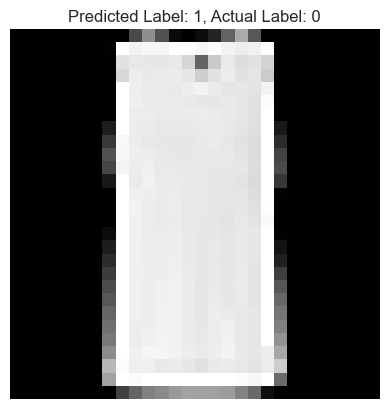

In [313]:
image_index = 27

# Extract the test image and label
test_image = x_test[image_index]
test_label = np.argmax(y_test[image_index])

# Reshape the test image for prediction (Keras expects a batch dimension)
test_image_reshaped = np.expand_dims(test_image, axis=0)

# Make predictions on the test image
predicted_label = np.argmax(model.predict(test_image_reshaped), axis=-1)

# Plot the test image with predicted and actual labels
plt.imshow(test_image, cmap='gray')
plt.title(f'Predicted Label: {predicted_label[0]}, Actual Label: {test_label}')
plt.axis('off')
plt.show()

### Just to explore TensorFlow Implemenation of CNN.

Not Required For Submission.

In [314]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Load the Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Define the CNN model
model = models.Sequential([
    layers.Conv2D(16, (5, 5), activation='sigmoid', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='tanh'),
    layers.MaxPooling2D((3, 3)),
    layers.Flatten(),
    layers.Dense(128, activation='softmax'),
    layers.Dense(10)
])

# Compile the model
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
model.fit(train_images.reshape(-1, 28, 28, 1), train_labels, epochs=5)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images.reshape(-1, 28, 28, 1), test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.0972 - loss: 2.3027
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.1005 - loss: 2.3026
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.0972 - loss: 2.3026
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.1016 - loss: 2.3026
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.1019 - loss: 2.3026
313/313 - 1s - 4ms/step - accuracy: 0.1615 - loss: 2.3025

Test accuracy: 0.1615000069141388


## AUTOMATED TUNING (EXETENDED)

In [315]:
# https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams